In [3]:
import os
import tarfile

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["figure.facecolor"]="#ffffff"

In [8]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"

In [9]:
dataset_url

'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'

In [10]:
download_url(dataset_url, ".")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 135107811/135107811 [01:12<00:00, 1875482.30it/s]


In [11]:
with tarfile.open("./cifar10.tgz", "r:gz") as tar:
    tar.extractall(path="./data")

In [12]:
data_dir = "./data/cifar10/"
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['automobile', 'airplane', 'ship', 'frog', 'truck', 'dog', 'bird', 'cat', 'horse', 'deer']


In [14]:
# Data transforms {normalization, data augmentation}
# ((mean, mean, mean), (std, std, std)) => {R,G,B}
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode="reflect"),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True),
#                          tt.RandomRotate,
#                          tt.RandomResizedCrop(256, scale=(.5, .9), ratio=(1,1)),
#                          tt.ColorJitter(brightness=.1, contrast=.1, 
#                                         saturation=.1, hue=.1)
])

valid_tfms = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [15]:
# Dataset
train_ds = ImageFolder(data_dir+"/train", train_tfms)
val_ds = ImageFolder(data_dir+"/test", valid_tfms)

In [16]:
# batch size
batch_size = 400

In [17]:
# dataloader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

In [23]:
# denormalize the image and show the batch
def denorm(imgs, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return imgs * stds + means   # normed = (x - mean) / std

def show_batch(dl):
    for imgs, labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_imgs = denorm(imgs, *stats)
        ax.imshow(make_grid(denorm_imgs[:36], nrow=6).permute(1,2,0).clamp(0,1))
        break

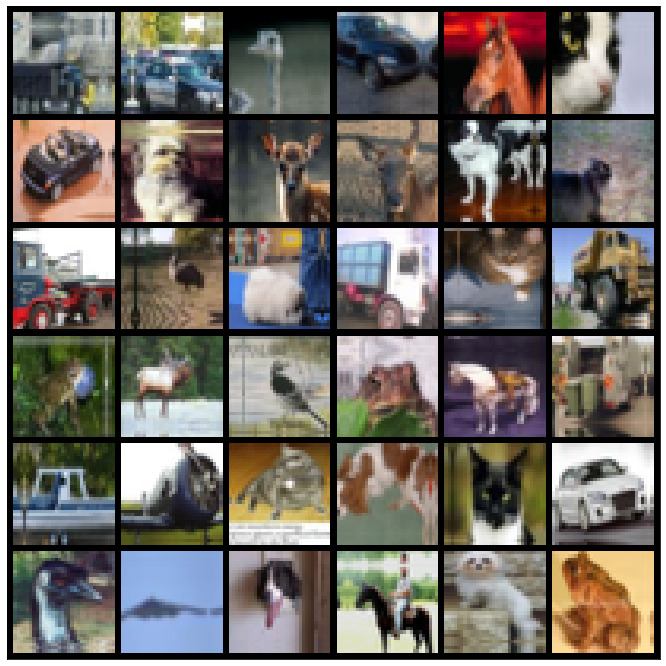

In [24]:
show_batch(train_dl)

In [26]:
# Device and to device
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [27]:
# Device and dataloader
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)OM

In [28]:
device = get_default_device()
device

device(type='cuda')

In [29]:
# wrap train and test with dataloader
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(valid_dl, device)

# Resnet 
https://github.com/JayPatwardhan/ResNet-PyTorch/tree/master/ResNet

In [30]:
class SimplResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=3, 
            kernel_size=3, stride=1,
            padding=1
)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=3, out_channels=3,
            kernel_size=3, stride=1,
            padding=1
)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        """
        Applying relu before or after adding the input
        """
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [31]:
simple_resnet = to_device(SimplResidualBlock(), device)

for imgs, labels in train_dl:
    out = simple_resnet(imgs)
    print(out.shape)
    break
    
del simple_resnet, imgs, labels

torch.Size([400, 3, 32, 32])


/home/loveplay1983/Workstation/Anaconda/anaconda/envs/torch/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [32]:
torch.cuda.empty_cache()

In [33]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [36]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        imgs, labels = batch
        out = self(imgs)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        imgs, labels = batch
        out = self(imgs)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss" : loss.detach(), "val_acc": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]